# Libraries

In [1]:
import os, os.path
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

import glob
import pickle

# Working place

In [2]:
place = 'local'

def vs_to_colab(place='local'):
    """This function is to set the path of the working place, depending if we are working online or local

    Args:
        place (str): Name of the place. Two options. Defaults to 'local'.
    """
    if (place=='local'):
        os.chdir('/home/ricardino/Documents/MAIA/tercer_semestre/CAD/Projecte_1')
    elif (place=='online'):
        os.chdir('/content/drive/MyDrive/MAIA/3rd_semester/CAD/Projecte_1')
    else:
        print('Not accepted working place, try again')
        
    return os.getcwd()

main_path = vs_to_colab(place='local')


# Functions

In [3]:
def count_elements(classif, set_name, class_name):
    """Function to count the number of elements on each folder

    Args:
        classif (str): classification (binary or 3-class)
        folder (str): trian or test
        class_name (str): name of the class
    """
    vs_to_colab(place=place)
    os.chdir(f'images/{classif}/{set_name}/{class_name}/')
    num_elemets = len([name for name in os.listdir('.') if os.path.isfile(name)])
    print(f'Elements in {os.getcwd()}: {num_elemets}')
    vs_to_colab(place=place)
    
def get_paths(classif, set_name, class_name):
    """This function extracts the paths of all files in a folder, given the classifiation problem (binary, 3-class), the set name (train-val-test), and the class name
    (endpoint) of the diagnosis.
    It returns a list with all the paths in string.

    Args:
        classif (str): binary or 3-class
        set_name (str): train, val or test
        class_name (str): lesions name (nevus, etc.)
    """
    #path of the folder to check
    folder_path = main_path + f'/images/{classif}/{set_name}/{class_name}'
    #extract all items in the folder that are jpg
    train_f1 = glob.glob(folder_path+ '/*.jpg')
    
    return train_f1

class path_and_label:
    """This class is for storing paths and labels of all images in the dataset, for a given classification problem, set name and class name.
    """
    def __init__(self,classif,set_name,class_name) -> None:
        folder_path = main_path + f'/images/{classif}/{set_name}/{class_name}' #Go to folder
        self.paths = glob.glob(folder_path+ '/*.jpg') #Get paths
        self.labels = np.zeros(len(self.paths),dtype=np.uint8) #Define labels
        if class_name in ['nevus', 'mel']: #if belonging to label 1
            self.labels = self.labels + 1
        elif class_name in ['scc']: #if belonging to label 2
            self.labels = self.labels + 2

class path_holder:
    """The objects of this class will contain all the paths and labels.
    """
    def __init__(self) -> None:
        pass
    binary_train_nevus = path_and_label('binary','train','nevus') #Path and label of train nevus
    binary_train_others = path_and_label('binary','train','others') #Path and label of train others
    binary_val_nevus = path_and_label('binary','val','nevus') #Path and label of nevus others
    binary_val_others = path_and_label('binary','val','others') #Path and label of val others
    
    multi_train_bcc = path_and_label('3_classes','train','bcc') #Path and label of train nevus
    multi_train_mel = path_and_label('3_classes','train','mel') #Path and label of train nevus
    multi_train_scc = path_and_label('3_classes','train','scc') #Path and label of train nevus
    
    multi_val_bcc = path_and_label('3_classes','val','bcc') #Path and label of train nevus
    multi_val_mel = path_and_label('3_classes','val','mel') #Path and label of train nevus
    multi_val_scc = path_and_label('3_classes','val','scc') #Path and label of train nevus
    
    
    
# An "interface" to matplotlib.axes.Axes.hist() method
def histogram_ch1(x):
    """Gives hitogram of 1 channle image

    Args:
        x (2D array): 1 channel image form which histogram is gona be computed
    """
    n, bins, patches = plt.hist(x.ravel(), bins='auto', color='#0504aa',
                                alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Hue histogram')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


In [4]:
#function that performs the sum of the structure elements in different directions
def sum_operation_se_different_directions(img,operation, width,height,n_se):
    """This function performes the sum of the structure element in different direction

    Args:
        img (array): image to process
        operation (cv.method): top-hat, buttom-hat
        width (int): width of stucturing element
        height (int): geight of the structuring element
        n_se (int): number of angles

    Returns:
        _type_: _description_
    """
    # create SEs
    base = np.zeros([width, width])
    k = int(width / 2 - height / 2)
    while k <= (width / 2 + height / 2):
        base = cv.line(base, (0, k), (width, k), 255) #drawing a line
        k = k + 1
    
    SEs = []
    SEs.append(base)
    angle = 180.0 / n_se
    #Aplying affine transformations to the elements 
    for k in range(1, n_se):
        SEs.append(cv.warpAffine(base, cv.getRotationMatrix2D((base.shape[0] / 2, base.shape[1] / 2), k * angle, 1.0),(width, width)))
    
    #Performing the sum of the elements with a morphology operation, in this case blackhats
    open_sum = np.uint16(0*cv.morphologyEx(img, operation, np.uint8(SEs[0])))
    for se in SEs:
        open_sum += cv.morphologyEx(img, operation, np.uint8(se))
    #Applying the normalization
    result= cv.normalize(open_sum, 0, 255, norm_type=cv.NORM_MINMAX)
    return np.uint8(result)


def smplextract_hair(src):
    """This function inputs an skin lesion image and returns the preprocessed image without hairs and enhancing contrast.

    Args:
        src (3-channel array): Input image in 3 channels

    Returns:
        3-channel array: preprocessed image
    """
    
    # Convert the original image to grayscale
    img_gray=cv.cvtColor(src,cv.COLOR_BGR2GRAY)
    #Applying the contrast enhance to the image, setting a contrast limit to avoid noise amplification
    clahe = cv.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
    contrast_enhanced_gray_img = clahe.apply(img_gray)

    #Selecting the size and number of structure elements
    width= 29
    height=2
    n_se=15
    
    #cv.imshow("original_image",src)
    #Performing the sum of black hats in order to obtain the contours of the hairs with respect to the direction
    sum_black_hats=sum_operation_se_different_directions(contrast_enhanced_gray_img,cv.MORPH_BLACKHAT, width,height,n_se)
    #cv.imshow("sum_blackhats", sum_black_hats)
    #Applying the threshold to increase the pixel intensities in the mask
    ret, bin_img = cv.threshold(sum_black_hats, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    #cv.imshow("Thresholded Mask",bin_img)
    #Applying dilation to prepare the mask for the next step
    dilated_bin_img=cv.dilate(bin_img,cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)))
    #cv.imshow("dilated", dilated_bin_img)
    # Inpaint the original image depending on the mask
    dst = cv.inpaint(src,dilated_bin_img,7,cv.INPAINT_TELEA)
    #cv.imshow("Inpaint",dst)
    #cv.waitKey(50)
    return dst

    

# Couting elements in folders

In [5]:
count_elements(classif='binary', set_name='train', class_name='others')

Elements in /home/ricardino/Documents/MAIA/tercer_semestre/CAD/Projecte_1/images/binary/train/others: 7470


# Getting paths

In [6]:
#Define instance with all paths
data = path_holder()

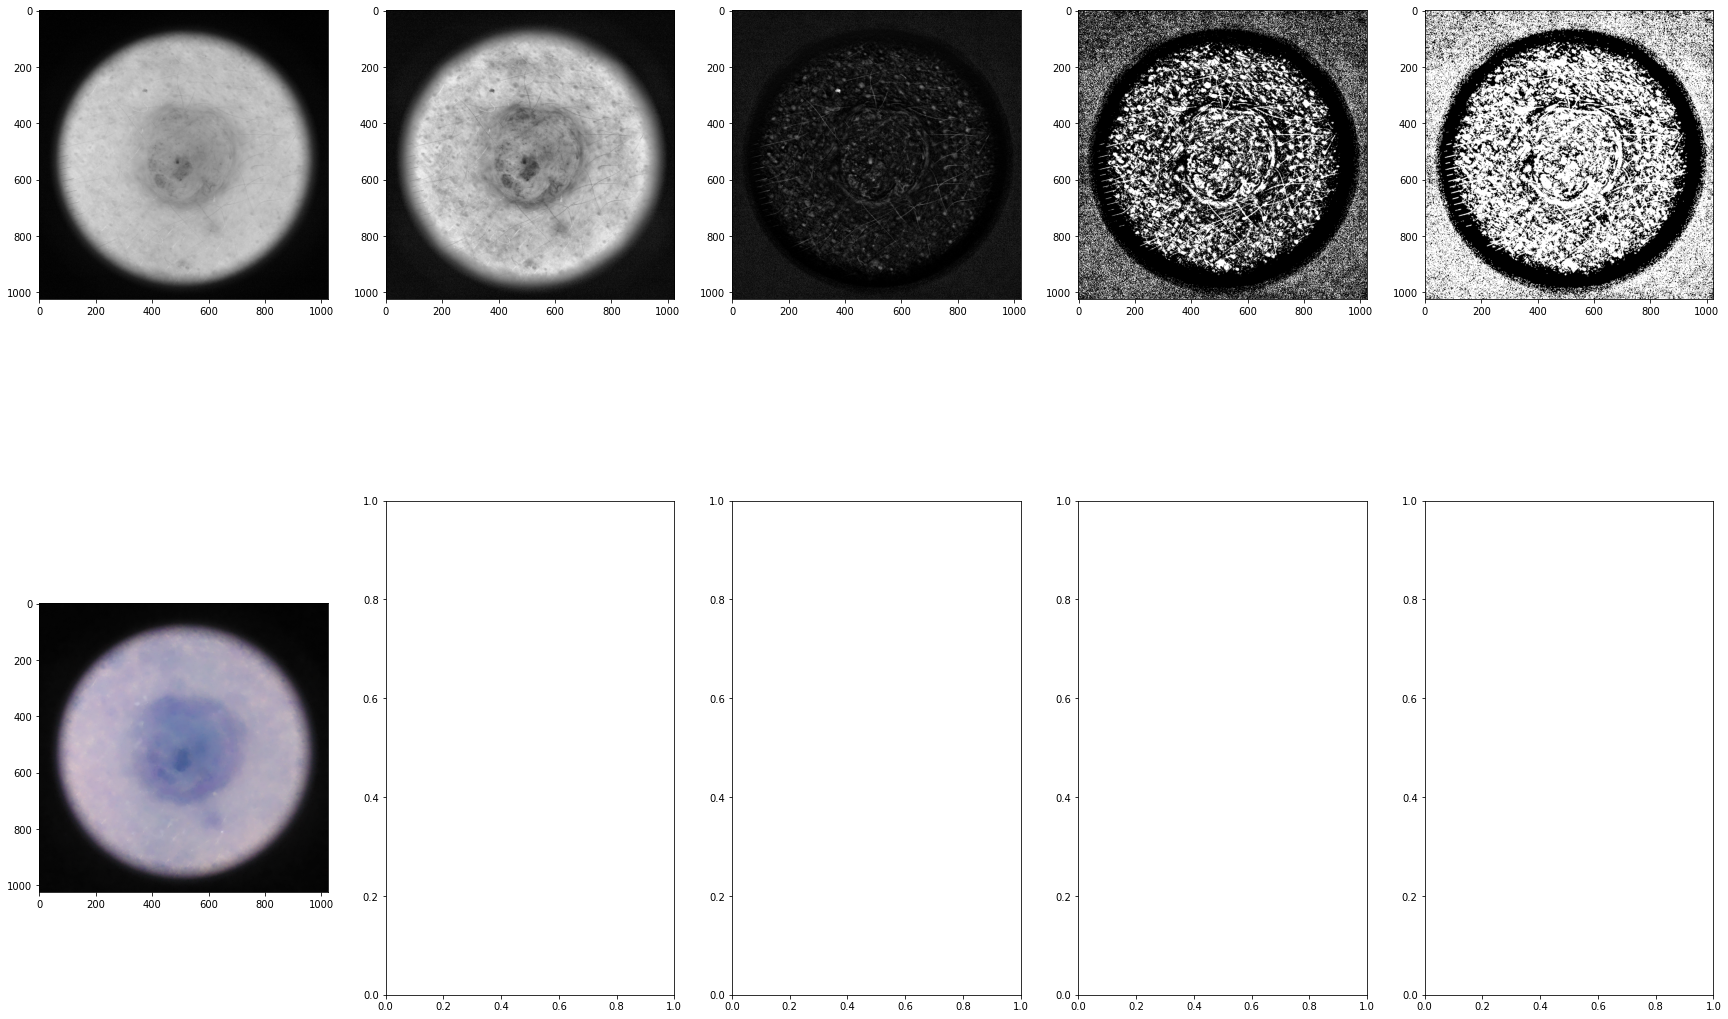

In [7]:
im_path = data.binary_train_nevus.paths[1]

im = cv.imread(im_path)

# Convert the original image to grayscale
img_gray=cv.cvtColor(im,cv.COLOR_BGR2GRAY)
#Applying the contrast enhance to the image, setting a contrast limit to avoid noise amplification
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
contrast_enhanced_gray_img = clahe.apply(img_gray)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(30,20))
axs[0,0].imshow(img_gray, cmap='gray')
axs[0,1].imshow(contrast_enhanced_gray_img, cmap='gray')

width= 29
height=2
n_se=15

#cv.imshow("original_image",src)
#Performing the sum of black hats in order to obtain the contours of the hairs with respect to the direction
sum_black_hats=sum_operation_se_different_directions(contrast_enhanced_gray_img,cv.MORPH_BLACKHAT, width,height,n_se)

axs[0,2].imshow(sum_black_hats, cmap='gray')

ret, bin_img = cv.threshold(sum_black_hats, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

axs[0,3].imshow(bin_img, cmap='gray')

dilated_bin_img=cv.dilate(bin_img,cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)))

axs[0,4].imshow(dilated_bin_img, cmap='gray')

dst = cv.inpaint(im,dilated_bin_img,7,cv.INPAINT_TELEA)

axs[1,0].imshow(dst)

# Alex's Idea

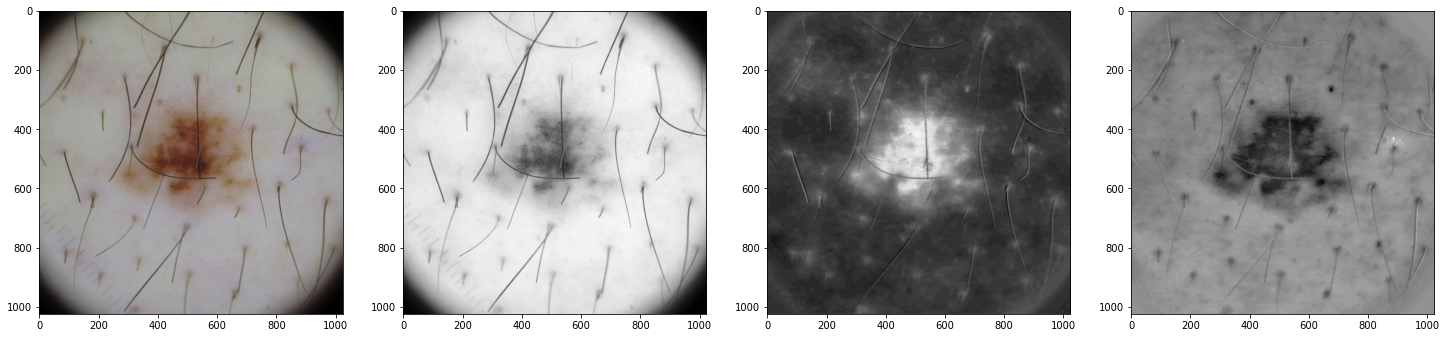

In [8]:
im_path = data.binary_train_nevus.paths[15]
im_path = 'images/binary/train/nevus/nev00011.jpg'
im_bgr = cv.imread(im_path)
im_rgb = cv.cvtColor(im_bgr, cv.COLOR_BGR2RGB)
im_ycbcr = cv.cvtColor(im_bgr, cv.COLOR_BGR2YCrCb)
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(25,10))
axs[0].imshow(im_rgb)
axs[1].imshow(im_ycbcr[:,:,0], cmap='gray')
axs[2].imshow(im_ycbcr[:,:,1], cmap='gray')
axs[3].imshow(im_ycbcr[:,:,2], cmap='gray')

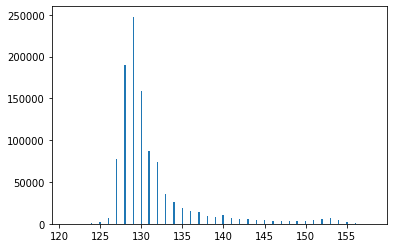

In [9]:
plt.hist(im_ycbcr[:,:,1].ravel(),bins=255);

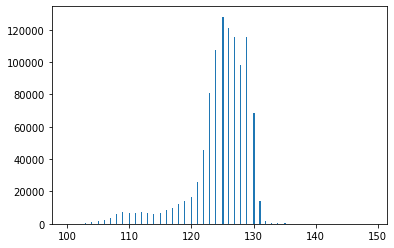

In [10]:
plt.hist(im_ycbcr[:,:,2].ravel(),bins=255);

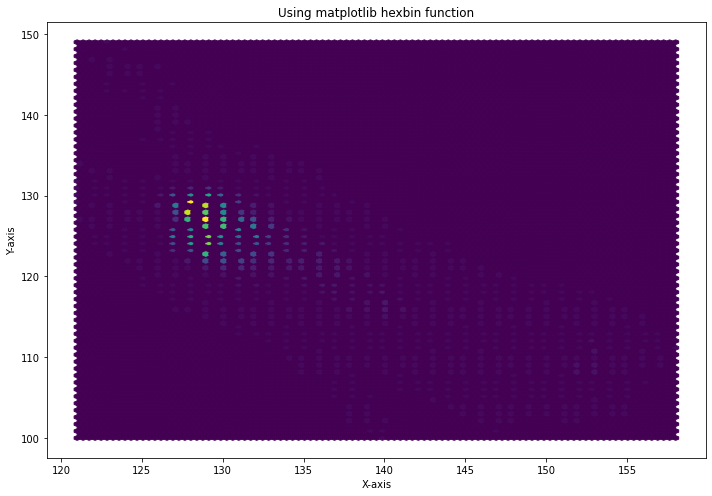

In [11]:
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.title("Using matplotlib hexbin function") 
plt.hexbin(im_ycbcr[:,:,1].ravel(), im_ycbcr[:,:,2].ravel(), bins = 50) 
  
ax.set_xlabel('X-axis')  
ax.set_ylabel('Y-axis')  
  
plt.tight_layout()  

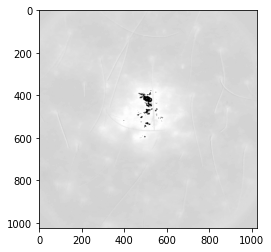

In [12]:
#Color channels
cb = im_ycbcr[:,:,1]
cr = im_ycbcr[:,:,2]
plt.imshow(cb*(cb<155),cmap='gray')